In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from xgboost import XGBRegressor


İmporting the Poland House Price Dataset

In [9]:
house_price = pd.read_csv("/content/Houses.csv", encoding="cp1252")

print(house_price.shape)
house_price.head()

(23764, 11)


,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [23]:
# Remove unnecessary index column (if it exists)
if "Unnamed: 0" in house_price.columns:
    house_price = house_price.drop(columns=["Unnamed: 0"])

# Quick cleaning for outliers/corrupted spaces, etc.
house_price = house_price.drop_duplicates().reset_index(drop=True)

# Check target column (already exists in your data)
assert "price" in house_price.columns, "Column 'price' not found in CSV!"

In [ ]:
numeric_features = ["floor", "latitude", "longitude", "rooms", "sq", "year"]

# Categorical feature(s): 'address' is too free-text and would add noise to the model; 'city' is sufficient for now
categorical_features = ["city"]

# Ensure these columns actually exist
numeric_features = [c for c in numeric_features if c in house_price.columns]
categorical_features = [c for c in categorical_features if c in house_price.columns]

X = house_price[numeric_features + categorical_features].copy()
y = house_price["price"].astype(float)

# Some numerical columns might have come in as strings; convert to numeric (coerce errors to NaN)
for c in numeric_features:
    X[c] = pd.to_numeric(X[c], errors="coerce")

# Simple missing value strategy: median for numerical, 'missing' for categorical
for c in numeric_features:
    X[c] = X[c].fillna(X[c].median())

for c in categorical_features:
    X[c] = X[c].fillna("missing")

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ],
    remainder="drop",
)

model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", model)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['floor', 'latitude',
                                                   'longitude', 'rooms', 'sq',
                                                   'year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.9, device=N...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=600, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [27]:
pred_train = pipe.predict(X_train)
pred_test  = pipe.predict(X_test)

def evaluate(y_true, y_pred, name=""):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:,.2f} | RMSE: {rmse:,.2f} | R2: {r2:.3f}")

evaluate(y_train, pred_train, "Train")
evaluate(y_test, pred_test, "Test")

Train -> MAE: 50,488.29 | RMSE: 87,844.01 | R2: 0.973
Test -> MAE: 74,296.79 | RMSE: 205,572.82 | R2: 0.837


In [28]:
# Capture all feature names generated after ColumnTransformer
ohe = pipe.named_steps["prep"].named_transformers_.get("cat", None)
feature_names = []

In [29]:
# Numerical feature names
feature_names.extend(numeric_features)

In [30]:
# Categorical -> OneHot names
if ohe is not None and len(categorical_features) > 0:
    ohe_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names.extend(ohe_names)

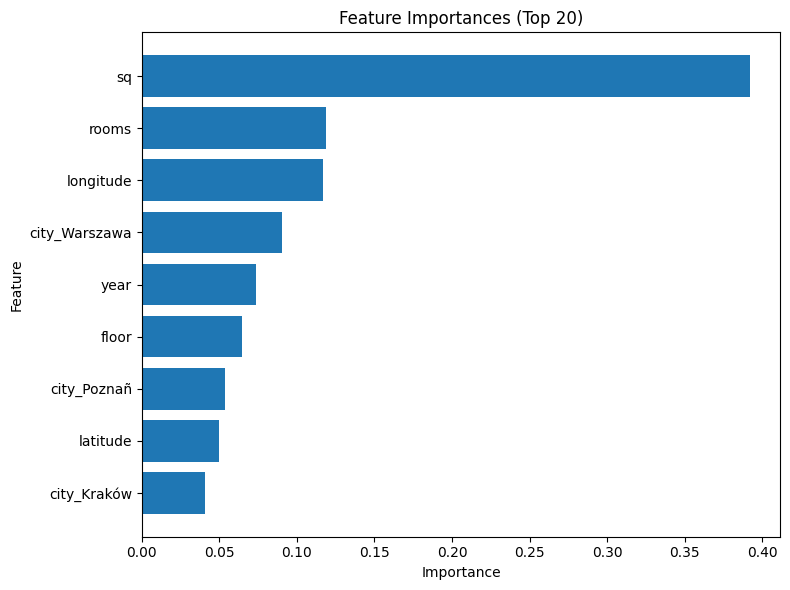

In [31]:
# XGB feature importance
importances = pipe.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(
    "importance", ascending=False
).head(20)

plt.figure(figsize=(8, 6))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Feature Importances (Top 20)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()